# Sequential data modelling
In this notebook we will try to improve on our previous temperature prediction model using the Jena weather dataset. We will try to create a more realistic RNN model which treats the data as a single sequence. In addition to these improvments we will use regularisation techniques to reduce overfitting.

In hopes to get the yearly, seasonal, patterns into our model, we will sample the data weekly and have a sequence length of a year and predict the temperature next week. If everything works out, we could effectively predict the same temperature as last year! By sub-sampling our data weekly, we make sure that our sequences are not too long but are still able to capture the seasonal changes. In order to have enough training data, we will only shift 1 datapoint forward in each iteration of sequence generation. 

The plan in this notebook is to;
1. Load data and some cleaning.
1. Sub-sample data for every week.
1. Create sequences.
1. Split data.
1. Scale data.
1. Baseline GRU RNN.
1. Stateful GRU.
1. Dropout applied to GRU.
1. Train on all data (no validation) and evaluate

We will provide more code in this notebook in order to get quicker to the modelling steps.

In [15]:
library(keras)
library(ggplot2)
source("05-helpers.R")

use_multi_cpu(2L)
# This specifies the number of threads TensorFlow will use. You can change this number, 
# but it depends on the model, what the optimal number of threads might be.
# In my experiments 2 threads performed quite well for simpleRNNs.
# Using more than 2 threads increased communication overhead and decreased the training speed.
# To change this value simply set the value which you want and then click "Kernel" -> "Shutdown" and then "Kernel" -> "Restart".
# If you do not shutdown the kernel, the change will not take effect.

## 1. Load and clean data

In [4]:
raw_data <- load_jena_dataset()

Parsed with column specification:
cols(
  `Date Time` = col_character(),
  `p (mbar)` = col_double(),
  `T (degC)` = col_double(),
  `Tpot (K)` = col_double(),
  `Tdew (degC)` = col_double(),
  `rh (%)` = col_double(),
  `VPmax (mbar)` = col_double(),
  `VPact (mbar)` = col_double(),
  `VPdef (mbar)` = col_double(),
  `sh (g/kg)` = col_double(),
  `H2OC (mmol/mol)` = col_double(),
  `rho (g/m**3)` = col_double(),
  `wv (m/s)` = col_double(),
  `max. wv (m/s)` = col_double(),
  `wd (deg)` = col_double()
)


We remove the `Date Time` feature from `raw_data` and store the result in a variable called `data`.

In [5]:
data <- raw_data[,-1]
dim(data)

[1] 420551     14

## 2. Sub-sampling
Let us now sub-sample our data by selecting a data point every week. Since our data has a measurement every 10 minutes we need to sample every 6 * 24 * 7 = 1008 data point. We use the same method as in the previous notebook to do this, the [`seq()`](https://www.rdocumentation.org/packages/base/versions/3.5.3/topics/seq) function.

In [7]:
dim(data)
data_weekly = data[seq(1, nrow(data), 1008),]
dim(data_weekly)

[1] 420551     14

[1] 418  14

These are not that many datapoints, but let us see if we can still see the seasonal pattern in the data.

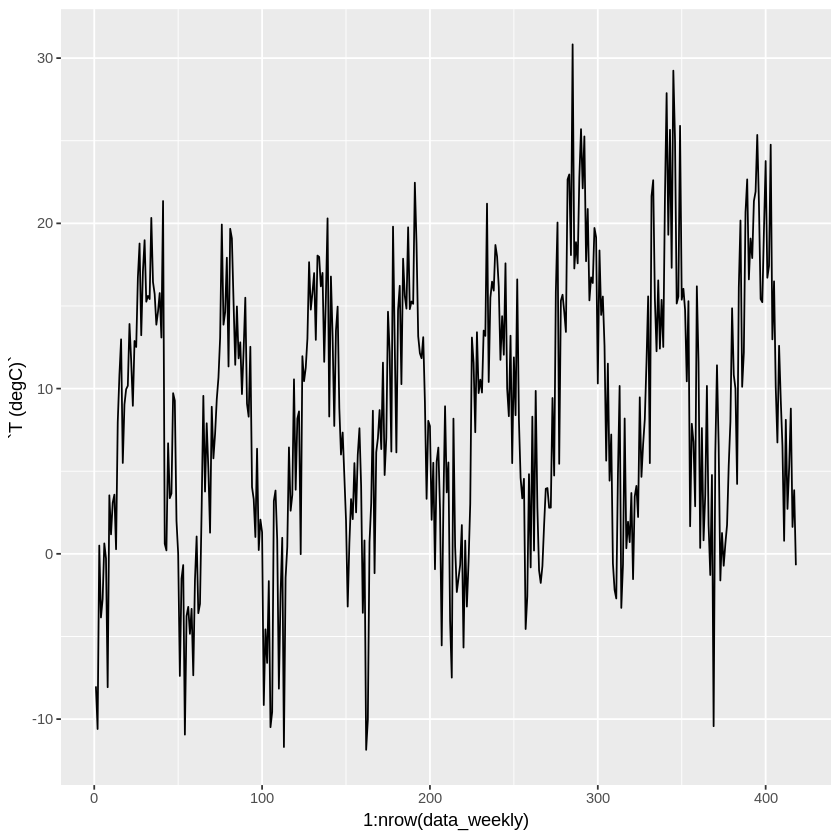

In [8]:
ggplot(data_weekly, aes(x = 1:nrow(data_weekly),y=`T (degC)`)) + geom_line()

## 3. Creating sequences
Now we need to create sequences from our weekly data. To be sure that we get enough datapoints we will only shift a single data-point between sequences and predict the temperature next week. The function `create_sequences_x_y()` which we wrote in the last notebook is available for us to use.

## Exercise 1
Create the sequences we need by filling in the `create_sequences_x_y()` function and save them as `x_weekly` and `y_weekly`. Check your work by checking the dimensions of `x_weekly` and `y_weekly`. The dimensions for `x_weekly` should be `(365, 52, 14)`. The number 365 are not days, we just happen to have that many data examples.

**Hint** Remember that the function takes 4 parameters; `data`, `sequence_length`, `target_shift` and `step_shift` and returns a list which contains `x` and `y`. If you are unable to find the correct values of these parameters, ask for help.

In [ ]:
out <- create_sequences_x_y(data = ?, sequence_length = ?, target_shift = ?, step_shift = ?)
x_weekly <- ?
y_weekly <- ?
dim(x_weekly)
dim(y_weekly)

In [10]:
out <- create_sequences_x_y(data = data_weekly, sequence_length = 52, target_shift = 1, step_shift = 1)
x_weekly <- out$x
y_weekly <- out$y
dim(x_weekly)
dim(y_weekly)

[1] 365  52  14

[1] 365  14

Then we eliminate the other features from `y_weekly` and only keep the temperature and store the result in `y_weekly_temp`.

In [12]:
y_weekly_temp <- y_weekly[,2]
length(y_weekly_temp)

[1] 365

## 4. Splitting
Now we split our data to train/test. Like in the previous notebook we use the last 20% of the data as a test set.

In [16]:
split_data <- split_dataset(x_data = x_weekly, y_data = y_weekly_temp, fraction = 0.2)
x_train = split_data$x_train
y_train = split_data$y_train
x_test = split_data$x_test
y_test = split_data$y_test
dim(x_train)
length(y_train)
dim(x_test)
length(y_test)

[1] 292  52  14

[1] 292

[1] 73 52 14

[1] 73

## 5. Scaling
The last preprocessing step, the scaling. This is exactly like in the previous notebook.

In [18]:
# We compute the mean and sd for each feature independently, The features are on the 3rd axis.
mean <- apply(x_train, 3, mean)
std <- apply(x_train, 3, sd)
# Create an empty 3D tensor with same dimensions as feature_matrix_reshaped.
x_train_scaled <- array(0, dim = dim(x_train))
x_test_scaled <- array(0, dim = dim(x_test))

# For each feature we subtract the mean and divide by the std.
for (j in 1:dim(x_train)[3]) {
    x_train_scaled[,,j] <- (x_train[,,j] - mean[j]) / std[j]
    x_test_scaled[,,j] <- (x_test[,,j] - mean[j]) / std[j]
}

## 6. The models
Now we will start with a GRU and try to improve it.

We have copied the network from the pervious notebook to the cell below but made some adjustments according to the changed problem.
- We added more units (32) to the GRU layer.
- We changed the input shape to account for a different sequence length.
- We use a batch size of 1. This is to compare to the next exercise in which we create a "stateful" GRU.

Making the batch size 1, will increase the training time considerably. While the model is training we suggest continue reading forward.

**Hint** To speed up training it is helpful to remove the `callbacks=list(Progress$new())` line from the `fit` function. The side-effect is that you have less idea of how far in the training process you are (you still the see the `*` on the left or the hourglass at the top), but you can be sure that it is about 1/5 faster.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_16 (GRU)                        (None, 32)                      4512        
________________________________________________________________________________
dense_14 (Dense)                    (None, 1)                       33          
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
________________________________________________________________________________


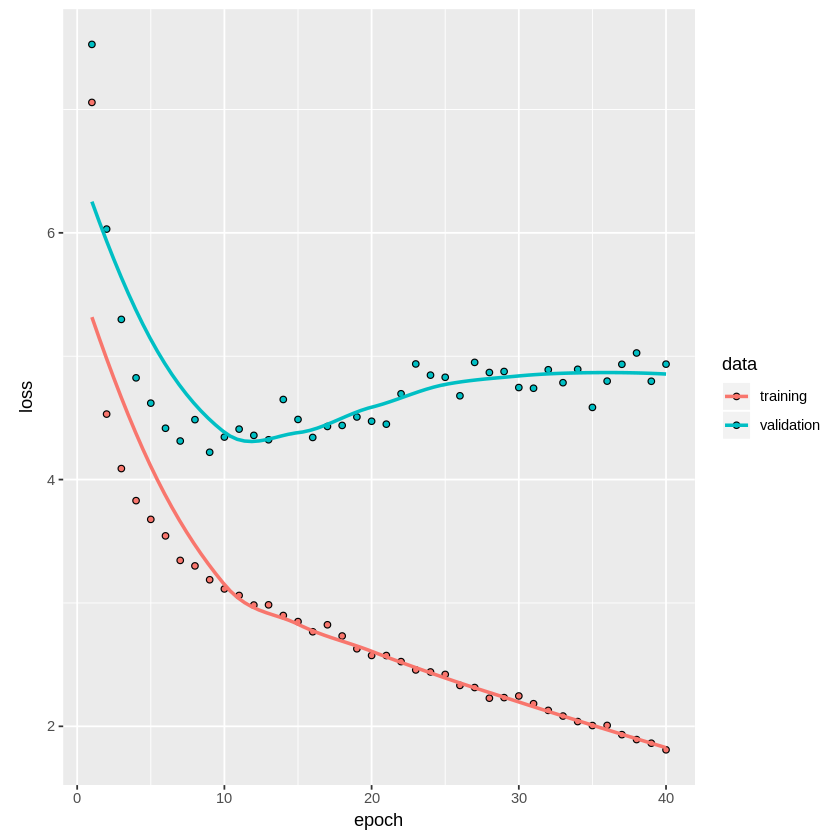

In [41]:
model <- keras_model_sequential() %>%
    layer_gru(units = 32, input_shape = c(52, 14)) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    epochs = 40,
    batch_size = 1,
    callbacks=list(Progress$new())
)

plot(history)

We should see an average validation loss of about 5 and the model is slighly overfitting.

## Stateful GRU
Let us now make this model stateful. When we make an RNN stateful, we pass the state, or the "memory", of the previous batch as an initial state to the next batch. This effectivly allows the model to treat the whole dataset as a single sequence, as we can pass information from the first time-step all the way to the last time-step. Keep in mind that the model only trains (updates the weight of the model) based on the data which is in the current sequence. For many use-case a stateful RNN is what many people look for in "production".

## Exercise 6.1
Copy the previous model to the cell below and set, `stateful = TRUE` in the [`layer_gru()`](https://keras.rstudio.com/reference/layer_gru.html) function. When making an RNN stateful we also need to provide `batch_input_shape = c(1, 52, 14)` into the `layer_gru()` function. Additinally, we need to make sure that Keras **DOES NOT SHUFFLE** our training examples between epochs, that is the default behavior. To change this, set `shuffle = FALSE` in the `fit()` function. If Keras were to shuffle our examples, the state which gets passed between batches would become meaningless.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_8 (GRU)                         (1, 32)                         4512        
________________________________________________________________________________
dense_6 (Dense)                     (1, 1)                          33          
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
________________________________________________________________________________


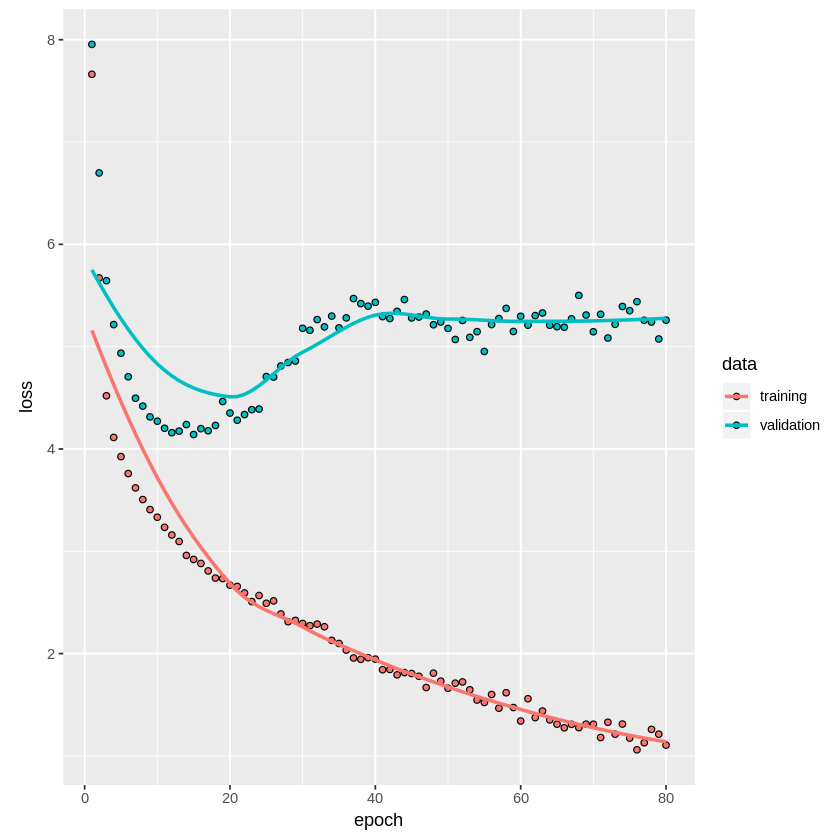

In [28]:
model <- keras_model_sequential() %>%
    layer_gru(units = 32, 
              batch_input_shape = c(1, 52, 14), 
              input_shape = c(52, 14), 
              stateful = TRUE) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    shuffle = FALSE,
    epochs = 40,
    batch_size = 1,
    callbacks=list(Progress$new())
)

plot(history)

It seems that our model starts overfitting the data even more when making it stateful. That's great! Of course, in the sense that it is good that making the model stateful allowed the model to train even more, meaning that the model benefits from the state being passed forward.

Let us try to fight this overfitting using some dropout.

## Exercise 6.2
Copy the previous model to the cell below and set some `recurrent_dropout` in the stateful [`layer_gru()`](https://keras.rstudio.com/reference/layer_gru.html). I found that a dropout value of 0.8 worked alright.

**Hint** To speed up training it is helpful to remove the `callbacks=list(Progress$new())` line from the `fit` function. The side-effect is that you have less idea of how far in the training process you are, but you can be sure that it is about 1/5 faster.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_18 (GRU)                        (1, 32)                         4512        
________________________________________________________________________________
dense_16 (Dense)                    (1, 1)                          33          
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
________________________________________________________________________________


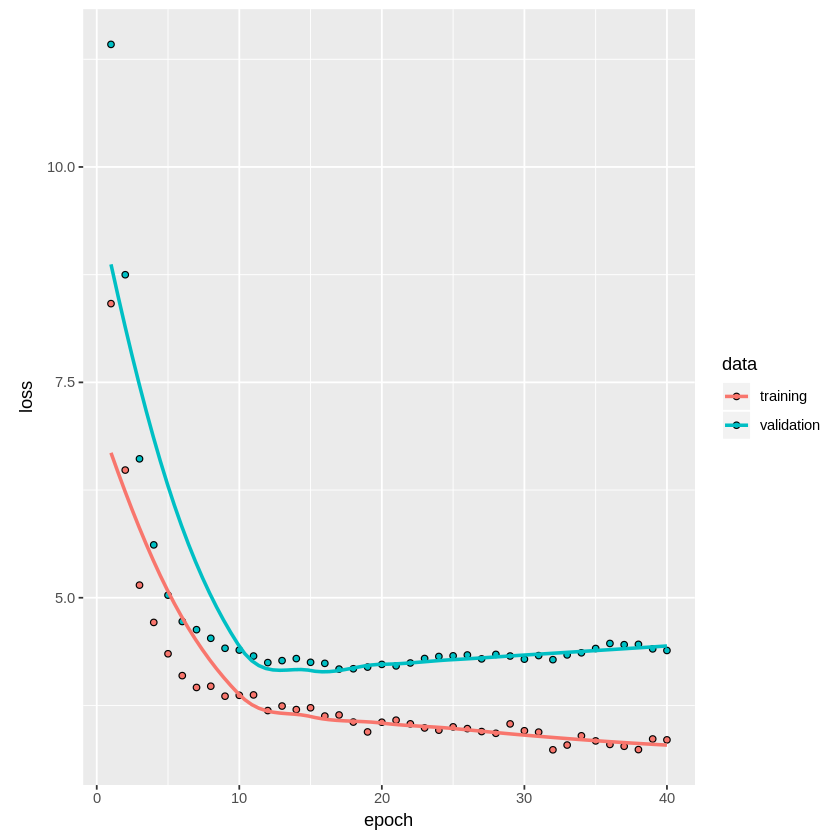

In [45]:
model <- keras_model_sequential() %>%
    layer_gru(units = 32, 
              batch_input_shape = c(1, 52, 14), 
              input_shape = c(52, 14), 
              recurrent_dropout = 0.8,
              stateful = TRUE) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    shuffle = FALSE,
    epochs = 40,
    batch_size = 1
)

plot(history)

When you are happy with the model and your hyperparameters we will train it one last time on all of the data and then evaluate it on the test set.

## Exercise 6.3
Copy the model from above and remove the `validation_split = 0.2` from the `fit()` function. This makes sure that we train all the data and the initial state to the test set is the last state, from the last sequence, from the training. Then run the cell below to evalute your model.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_20 (GRU)                        (1, 32)                         4512        
________________________________________________________________________________
dense_18 (Dense)                    (1, 1)                          33          
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
________________________________________________________________________________


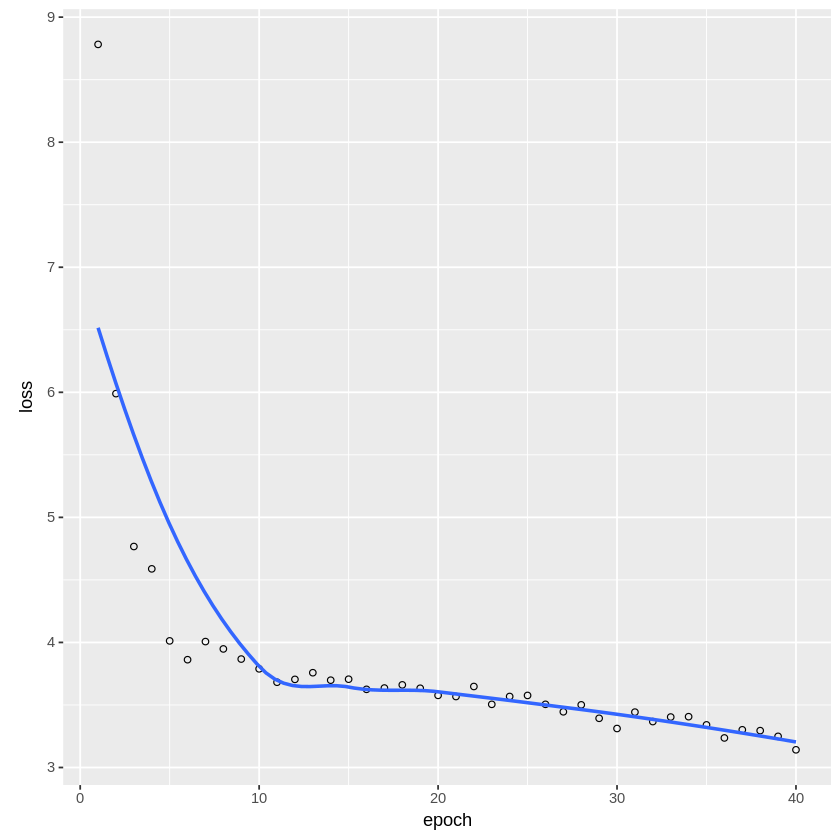

In [55]:
model <- keras_model_sequential() %>%
    layer_gru(units = 32, 
              batch_input_shape = c(1, 52, 14), 
              input_shape = c(52, 14), 
              recurrent_dropout = 0.8,
              stateful = TRUE) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    shuffle = FALSE,
    epochs = 40,
    batch_size = 1
)

plot(history)

In [61]:
model %>% evaluate(x_test_scaled, y_test, batch_size = 1)

loss 
5.080095

Let us also plot the actual temperature and the predicted temperature.

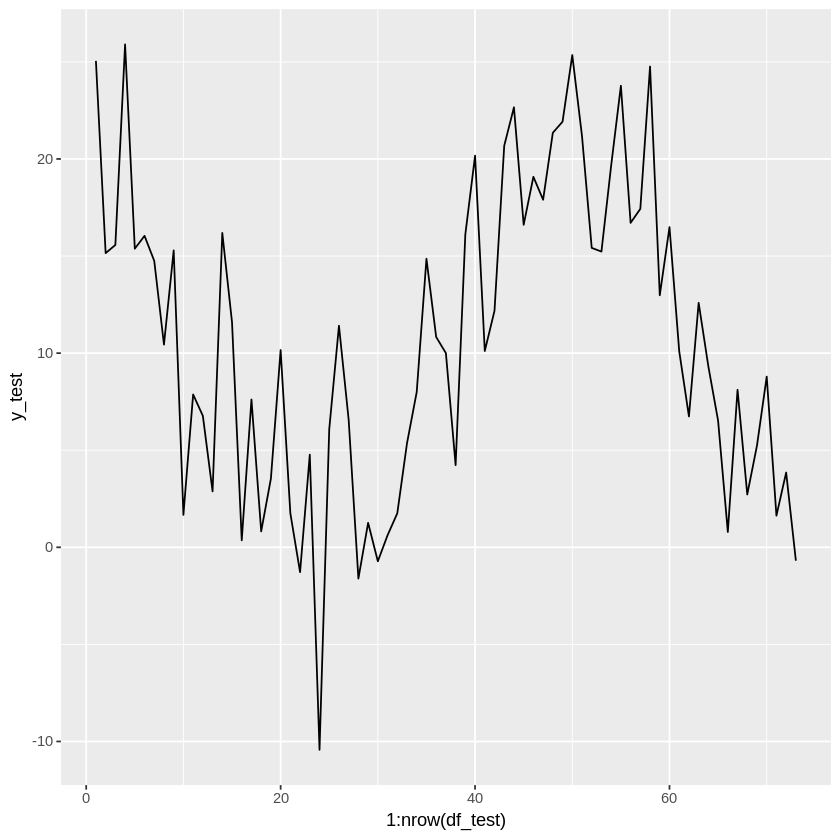

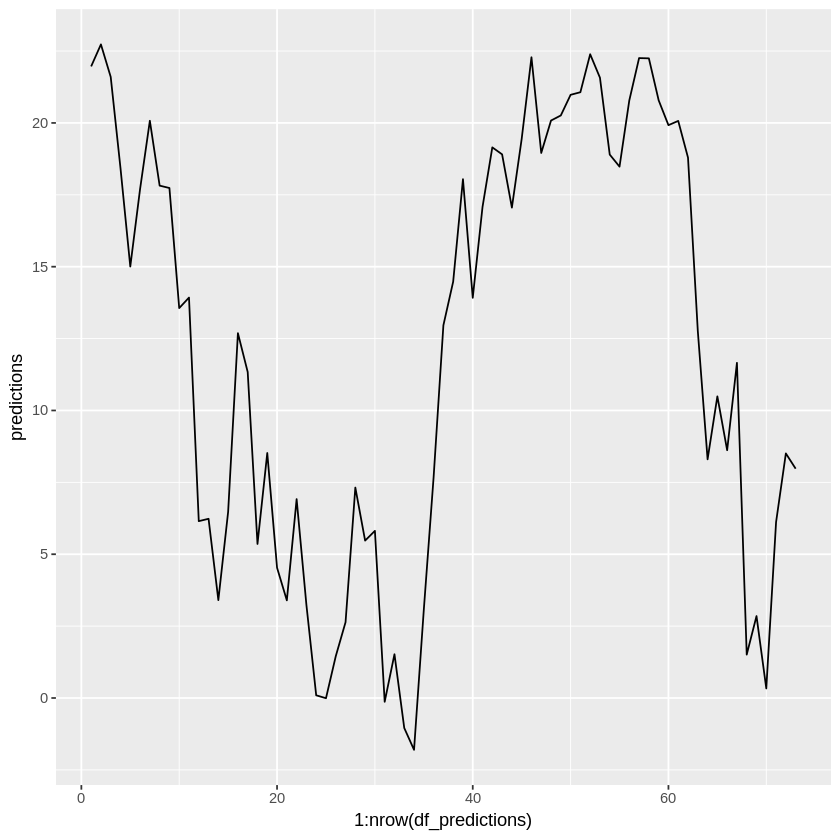

In [57]:
df_test <- data.frame(y_test)
ggplot(df_test, aes(x = 1:nrow(df_test),y=`y_test`)) + geom_line()

predictions <- model %>% predict(x_test_scaled, batch_size = 1)
df_predictions <- data.frame(predictions)
ggplot(df_predictions, aes(x = 1:nrow(df_predictions),y=`predictions`)) + geom_line()

Not too bad! It does not look to be directly copying the predictions of last year over and still looks something like our test data.

In this notebook we worked on an improved version of the temperature prediction problem.

- We sampled our data weekly and predicted the temperature next week. 
- We made sure that our sequences were long enough to process a years worth of data.
- We further improved our model so that it was stateful, storing and passing forward the state of the network between batches.
- We then applied recurrent dropout to regularise our model to reduce overfitting. 
- Lastly, we trained on all the training set before finally evaluating our model on the test set.

## Bonus exercise
Copy the model from above and try stacking 2 layers of GRUs. Add the `validation_split = 0.2` again. To stack RNNs we need to make sure that the first layer has the parameter `return_sequences = TRUE` but make sure that the later RNN does not. Be careful, stacking RNNs really kills your performance.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_25 (GRU)                        (1, 52, 32)                     4512        
________________________________________________________________________________
gru_26 (GRU)                        (1, 32)                         6240        
________________________________________________________________________________
dense_21 (Dense)                    (1, 1)                          33          
Total params: 10,785
Trainable params: 10,785
Non-trainable params: 0
________________________________________________________________________________


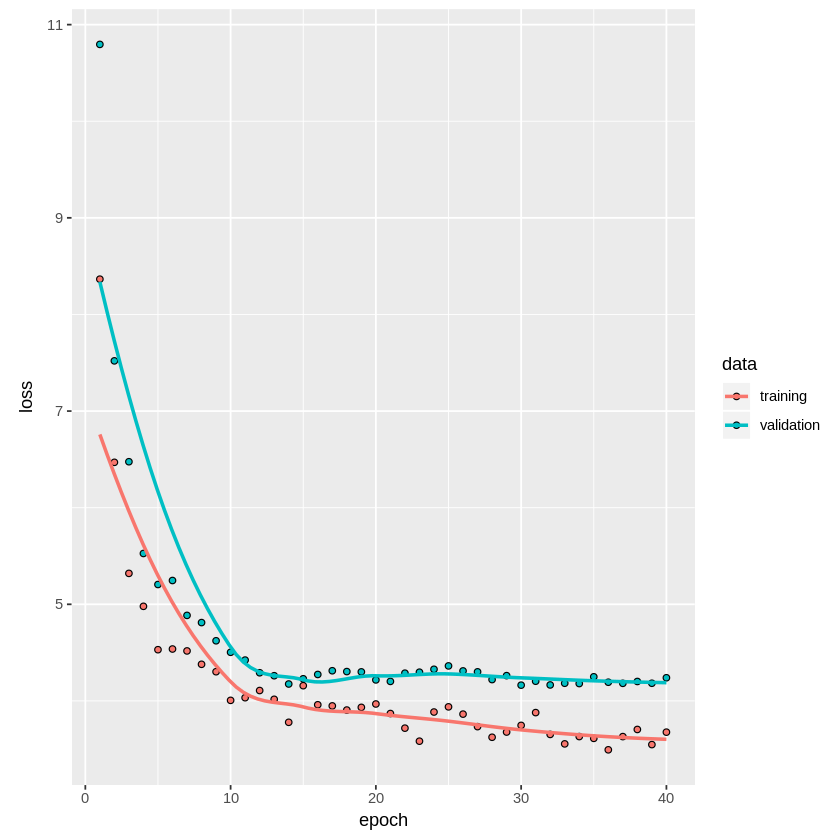

In [62]:
model <- keras_model_sequential() %>%
    layer_gru(units = 32, 
              batch_input_shape = c(1, 52, 14), 
              input_shape = c(52, 14), 
              recurrent_dropout = 0.8,
              stateful = TRUE,
              return_sequences = TRUE) %>%
    layer_gru(units = 32,
              dropout = 0.5,
              recurrent_dropout = 0.8,
              stateful = TRUE,
              return_sequences = FALSE) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    shuffle = FALSE,
    epochs = 40,
    batch_size = 1,
    callbacks=list(Progress$new())
)

plot(history)